In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_71715/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import os
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from pandas import Timestamp
import pytz
from timezonefinder import TimezoneFinderL

### Load dataframes

In [4]:
# data_dir = '/data/jupiter/alex.li/datasets/spring_dust_data_test'
# metadata_dir = '/data/jupiter/alex.li/dust/slow_df.parquet'

# data_dir = '/data/jupiter/datasets/Spring_hitchhiker_random'
# metadata_dir = '/home/alex.li/Spring_hitchhiker_random.parquet'
# dust_csv = f'/data/jupiter/datasets/Spring_hitchhiker_random/results_0808_1000000/dust_ratio.csv'

# data_dir = '/data/jupiter/datasets/hhh_field_data_stratified'
# dust_csv = f'/data/jupiter/alex.li/results/hhh_field_data_stratified/results_0808/dust_ratio.csv'
# metadata_dir = '/home/alex.li/data/get_dust_data/hhh.parquet'

data_dir = '/data/jupiter/datasets/apparent_dusty_day'
metadata_dir = '/home/alex.li/data/get_dust_data/apparent_dusty_day.parquet'
dust_csv = '/data/jupiter/alex.li/results/apparent_dusty_day/results_0808/dust_ratio.csv'

In [5]:
def read_data():
    print("Read annotations")
    df1 = pd.read_csv(os.path.join(data_dir, 'annotations.csv'), low_memory=False)
    print("Read metadata")
    df2 = pd.read_parquet(metadata_dir)
    if dust_csv != None:
        print("Read dust ratio")
        dust_ratio_df = pd.read_csv(dust_csv)
        print(f"image count {len(df1)} metadata size {len(df2)} dust size {len(dust_ratio_df)}")
        df = pd.merge(df1, dust_ratio_df, on='id', suffixes=('_x', None))
    else:
        df = df1
    df = pd.merge(df2, df, on='id', suffixes=('_x', None))
    print(f"Final dataset length {len(df)}")
    return df

# Add some columns

In [6]:
def speed_discrete(speed):
    if 0 <= speed <= 2:
        return "A:0-2"
    elif 2 < speed <= 10:
        return "B:2-10"
    elif 10 < speed <= 25:
        return "C:10-25"
    elif 25 < speed:
        return "D:25+"
    else:
        assert False
def camera_location_grouped(loc):
    match loc:
        # https://docs.google.com/document/d/1Qn-CosoeK8SdwaX-hYSWfGkbLTvYZaJDGWWVyJb9wgw/edit
        case 'I01'| 'I02'| 'I03'| 'I04'| 'I05'| 'I06'| 'I07'| 'I08':
            return 'halo_implement'
        case 'T01'| 'T02'| 'T03'| 'T04':
            return 'halo_front'
        case 'T05'| 'T06'| 'T07'| 'T08'| 'T13'| 'T14'| 'T15'| 'T16':
            return 'halo_side'
        case 'T09' | 'T10' | 'T11' | 'T12':
            return 'halo_rear'
        case 'front-center-left'| 'front-center-right':
            return 'rev1_front'
        case 'front-left-left'| 'front-left-right'| 'front-right-left'| 'front-right-right':
            return 'rev1_side_front'
        case 'side-left-left'| 'side-left-right'| 'side-right-left'| 'side-right-right':
            return 'rev1_side_rear'
        case 'rear-left'| 'rear-right':
            return 'rev1_rear'
    assert False
tf = TimezoneFinderL()
def get_adjusted_timezone(df_row):
    timestamp = pd.to_datetime(df_row['collected_on'])
    latitude, longitude = df_row['latitude'], df_row['longitude']
    if (latitude == 0) or (longitude == 0):
        return np.nan
    
    if isinstance(timestamp, np.datetime64):
        timestamp = pd.to_datetime(timestamp)

    # Localize and adjust UTC timestamps to local timezone
    utc =  pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz).to_pydatetime()

    return adjusted_timestamp
def get_day(t):
    return t.strftime("%m/%d")
def get_second(t):
    return t.strftime("%H:%M:%S")

In [7]:
try:
    df = pd.read_parquet(data_dir + '/df_cache.parquet')
except FileNotFoundError:
    df = read_data()
    print("add columns")
    df['speed'] = df.gps_can_data.apply(lambda a: ast.literal_eval(a).get('speed', 0))
    # df['wind_speed'] = df.weather_summary.apply(lambda a: ast.literal_eval(a).get('windspeed', 0))
    df['pred_dust_percent'] = df['pred_dust_ratio'] * 100
    try:
        df['collected_on'] = pd.to_datetime(df.collected_on)
    except Exception:
        df['collected_on'] = pd.to_datetime(df.collected_on, format='ISO8601')
    print("add weather columns")
    # df['weather_summary_json'] = df['weather_summary__json'].apply(json.loads)
    # df['temp'] = df['weather_summary_json'].apply(lambda x:x['temp'])
    # df['preciptype'] = df['weather_summary_json'].apply(lambda x:x['preciptype'])
    # df['dew'] = df['weather_summary_json'].apply(lambda x:x['dew'])
    # df['uvindex'] = df['weather_summary_json'].apply(lambda x:x['uvindex'])
    # df['visibility'] = df['weather_summary_json'].apply(lambda x:x['visibility'])
    # df['pressure'] = df['weather_summary_json'].apply(lambda x:x['pressure'])
    # df['humidity'] = df['weather_summary_json'].apply(lambda x:x['humidity'])
    # df['conditions'] = df['weather_summary_json'].apply(lambda x:x['conditions'])
    print("add discretization columns")
    df['dust>50'] = df['pred_dust_percent'] > 50
    df['dust>35'] = df['pred_dust_percent'] > 35
    df['dust>25'] = df['pred_dust_percent'] > 25
    df['dust>15'] = df['pred_dust_percent'] > 15
    df['dust>5'] = df['pred_dust_percent'] > 5
    df['is_rev1'] = df['robot_name'].apply(lambda x: x.split("_")[0])
    df['speed_discrete'] = df.speed_kph.apply(speed_discrete)
    # df['wind_speed_discrete'] = df.wind_speed.apply(speed_discrete)
    df['camera_location_grouped'] = df.camera_location.apply(camera_location_grouped)
    
    print("add time columns")
    df['collected_on_localtime'] = df.apply(get_adjusted_timezone, axis=1)
    df['daystr'] = df['collected_on_localtime'].apply(get_day)
    df['secstr'] = df['collected_on_localtime'].apply(get_second)
    print("save cache")
    df.to_parquet(data_dir + '/df_cache.parquet', index=False)

Read annotations
Read metadata
Read dust ratio
image count 13864 metadata size 13864 dust size 13864
Final dataset length 6912
add columns
add weather columns
add discretization columns
add time columns
save cache


# Visualize smudge data

In [14]:
# Dust when tractor is unmoving. some might say that it is... still
unmoving_dust = df[(df['speed_discrete'] == 'A:0-2') & df['dust>15']]

In [15]:
unmoving_groups = unmoving_dust.groupby(['camera_location', 'robot_name', 'daystr']).count()

In [16]:
dusty_unmoving_days = []
sorted_dusty_days = unmoving_groups.sort_values('id')
print(sorted_dusty_days[-30:])
dusty_unmoving_days = sorted_dusty_days[-30:].index[::-1]

Empty DataFrame
Columns: [id, hard_drive_name_x, robot_name_x, collected_on_x, bag_name_x, operating_field_name, operation_time_x, latitude_x, longitude_x, geohash_x, camera_location_x, sensor_type, created_at_x, bundle, gps_can_data__json, weather_summary__json, group_id_x, day, minute, speed_kph, artifact_debayeredrgb_0__id, artifact_debayeredrgb_0_content_hash, artifact_debayeredrgb_0_created_at, artifact_debayeredrgb_0_data_category, artifact_debayeredrgb_0_id, artifact_debayeredrgb_0_image, artifact_debayeredrgb_0_is_archived, artifact_debayeredrgb_0_kind, artifact_debayeredrgb_0_project_name, artifact_debayeredrgb_0_s3_bucket, artifact_debayeredrgb_0_s3_key, artifact_debayeredrgb_0_updated_at, artifact_debayeredrgb_0_web_s3_bucket, artifact_debayeredrgb_0_web_s3_key, artifact_raw_0__id, artifact_raw_0_content_hash, artifact_raw_0_created_at, artifact_raw_0_data_category, artifact_raw_0_id, artifact_raw_0_image, artifact_raw_0_is_archived, artifact_raw_0_kind, artifact_raw_0_proje

In [17]:
df_groups = df.groupby(['camera_location', 'robot_name', 'daystr']).groups

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ncols = 10
cats = [df.iloc[df_groups[info]].sample(ncols).sort_values('collected_on_localtime') for info in dusty_unmoving_days][:2]
page = 0
rows_per_cat = (4 + ncols) // 5
nrows = len(cats) * rows_per_cat
fig, ax = plt.subplots(nrows, 5, figsize=(16, nrows * 4))
for i, dust_df in enumerate(cats):
    ax0 = ax[i * rows_per_cat][0]
    info = dusty_unmoving_days[i]
    ax0.scatter(df.iloc[df_groups[info]]['collected_on_localtime'], df.iloc[df_groups[info]]['pred_dust_percent'])
    ax0.set_title(str(dusty_unmoving_days[i]))
    ax0.set_xlabel("Time of day")
    ax0.set_ylabel("Predicted dust level")
    tz = tf.timezone_at(lng=dust_df.iloc[0]['longitude'], lat=dust_df.iloc[0]['latitude'])
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax0.xaxis.set_major_locator(mdates.HourLocator(interval=3, tz=tz))
    for j in range(1, ncols):
        if j - 1 >= len(dust_df):
            break
        df_row = dust_df.iloc[j - 1 + page * ncols]
        im = cv2.imread(str(Path(data_dir) / df_row['artifact_debayeredrgb_0_save_path']))
        ax[i * rows_per_cat + j // 5][j % 5].imshow(im)
        ax[i * rows_per_cat + j // 5][j % 5].set_title(df_row['secstr'])

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

# Filters for data analysis

In [19]:
print(len(df))

6912


In [20]:
# Day that we know the tractor was doing useful work
# Based on https://docs.google.com/spreadsheets/d/1C9L1DYFe0uJKjbO-6BlknXdoczvXWYgExmOrPf_cODY/edit#gid=442100594
is_productive_103 = (df['robot_name'] == 'hitchhiker_103') & (df['daystr'].isin(['04/26', '04/27']))
is_productive_113 = (df['robot_name'] == 'hitchhiker_113') & (df['daystr'].isin(['04/15', '04/16', '04/28', '04/29', '05/01', '05/05', '05/23', '05/24', '05/25', '95/26']))
is_productive_123 = (df['robot_name'] == 'hitchhiker_123') & (df['daystr'].isin(['05/06', '05/19', '05/20', '05/22', '05/23', '05/25', '05/26']))
df['is_known_productive_day'] = is_productive_103 | is_productive_113 | is_productive_123
print(df['is_known_productive_day'].sum())

0


In [21]:
df['smudge_instance']  = (df['speed_discrete'] == 'A:0-2') & df['dust>15']
smudge_instance = df[df['smudge_instance']]
unmoving_no_dust_groups = smudge_instance.groupby(['robot_name', 'camera_location', 'daystr']).count()
smudge_days = unmoving_no_dust_groups.index
all_days = df_groups.keys()
no_smudge_days = list(set(all_days) - set(smudge_days))
all_valid_inds = []
for k in no_smudge_days:
    all_valid_inds.extend(list(df_groups[k]))
no_smudge_days_df = df.iloc[all_valid_inds]
df['no_smudge_today'] = df.index.isin(all_valid_inds)
print(df['no_smudge_today'].sum())

6912


In [22]:
less_columns = df[['pred_dust_percent', 'speed_discrete',  'dust>50', 'dust>35', 'dust>25', 'dust>15', 'dust>5',
                        'collected_on_localtime', 'is_rev1', 'camera_location', 'camera_location_grouped', 'is_known_productive_day',
                        'no_smudge_today', 'latitude', 'longitude', 'robot_name', 'operation_time', 
                        # 'conditions', 'dew', 'visibility', 'pressure', 'humidity','wind_speed_discrete', 'wind_speed'
                        'id', 'collected_on_localtime', 'speed_kph']].copy()
# less_columns.to_parquet(path_or_buf='/home/alex.li/git/scripts/notebooks/all_jup_dust.parquet')

In [23]:
# less_columns.columns
# less_columns.to_parquet(path_or_buf='/home/alex.li/git/scripts/notebooks/all_jup_dust.parquet')

In [24]:
threshold = 15
def percentage(c):
    return np.mean(c) * 100
agg_dict = {
    'dust>5': percentage,
    'dust>15': percentage,
    'dust>25': percentage,
    'dust>35': percentage,
    'dust>50': percentage,
    'id': 'size',
}
pd.set_option('display.max_rows', None)

In [59]:
# ALL DAYS
grouped_df = less_columns.groupby(['operation_time', 'camera_location_grouped', 'speed_discrete']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df.to_csv('/home/alex.li/logs/dust_analysis_all_agg.csv')
grouped_df

dust>5    dust>15  \
operation_time camera_location_grouped speed_discrete                         
daytime        front                   A:0-2            0.498836   0.149651   
                                       B:2-10           0.209950   0.036513   
                                       C:10-25          0.343682   0.183297   
                                       D:25+            1.559322   0.610169   
               front-side              A:0-2            0.732845   0.295636   
                                       B:2-10           0.483996   0.136980   
                                       C:10-25          0.564516   0.144009   
                                       D:25+            0.304054   0.067568   
               front_halo              A:0-2            3.355215   0.802334   
                                       B:2-10           1.229050   0.670391   
                                       C:10-25          1.154250   0.209864   
                                       D:25+            3.174603   0.793651   
               implement_halo          A:0-2            5.606407   4.233410   
                                       B:2-10          14.285714   9.461967   
                                       C:10-25         38.111888  27.447552   
                                       D:25+           12.686567   4.850746   
               rear                    A:0-2            1.106420   0.291163   
                                       B:2-10          10.486779   2.659255   
                                       C:10-25         16.595666   4.908316   
                                       D:25+           11.720430   4.516129   
               rear-side               A:0-2            0.625322   0.132421   
                                       B:2-10           2.399697   0.817562   
                                       C:10-25          4.863867   2.141209   
                                       D:25+            3.598281   0.966702   
               rear_halo               A:0-2            1.800554   0.484765   
                                       B:2-10           4.468085   1.808511   
                                       C:10-25         19.300000   8.900000   
                                       D:25+           11.190053   5.328597   
               side_halo               A:0-2            3.737024   2.422145   
                                       B:2-10           4.968619   2.928870   
                                       C:10-25          6.947891   3.771712   
                                       D:25+            4.102097   2.370100   
nightime       front                   A:0-2           25.861141  17.841765   
                                       B:2-10          31.152568  23.332481   
                                       C:10-25         33.542757  24.642234   
                                       D:25+           80.281690  70.422535   
               front-side              A:0-2           34.837497  23.771152   
                                       B:2-10          36.319674  27.411555   
                                       C:10-25         35.529831  26.785396   
                                       D:25+           78.730159  70.476190   
               front_halo              A:0-2            1.081081   0.000000   
                                       B:2-10           6.329114   2.531646   
                                       C:10-25          2.797203   1.398601   
                                       D:25+           55.555556   0.000000   
               implement_halo          A:0-2            3.174603   3.174603   
                                       B:2-10          15.662651   8.433735   
                                       C:10-25         22.807018  14.912281   
                                       D:25+            0.000000   0.000000   
               rear                    A:0-2           20.522529   8.405907   
                             

In [54]:
grouped_df = less_columns.groupby(['camera_location_grouped', 'is_rev1']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df = grouped_df[grouped_df['count'] > 200]
grouped_df.to_csv('/home/alex.li/workspace/dust_analysis_camera_locations.csv')
grouped_df

dust>5    dust>15    dust>25  \
camera_location_grouped is_rev1                                           
front                   hitchhiker      10.693369   8.907992   6.300775   
                        loamy            5.681228   3.457235   1.621228   
                        peaty           14.456965  11.316231   7.072644   
front-side              hitchhiker      10.726758   9.523360   8.263332   
                        loamy            7.567896   4.517137   3.196529   
                        peaty           16.299613  12.802517   9.462730   
                        triton          29.595016  29.595016  29.595016   
front_halo              halohitchhiker   2.798982   0.254453   0.254453   
                        hitchhiker       2.396313   0.768049   0.491551   
implement_halo          halohitchhiker  25.606469  18.328841  14.285714   
                        hitchhiker      15.856652  10.603829   7.560137   
rear                    hitchhiker      13.758865   6.256895   3.624901   
                        loamy           16.909866   7.338017   4.593767   
                        peaty           12.972714   5.385352   1.842987   
rear-side               hitchhiker       7.572472   4.288123   3.059504   
                        loamy            7.481932   3.982367   2.449996   
                        peaty            5.721637   3.259005   2.217594   
                        triton          28.703704  28.395062  28.395062   
rear_halo               halohitchhiker  10.451613   3.870968   1.935484   
                        hitchhiker       8.195429   4.045180   2.784345   
side_halo               bedrock          0.471698   0.471698   0.000000   
                        halohitchhiker   5.771644   3.952321   3.011292   
                        hitchhiker       4.769782   2.701958   1.985112   

                                          dust>35    dust>50  count  
camera_location_grouped is_rev1                                      
front                   hitchhiker       3.164557   1.832609  10586  
                        loamy            0.609693   0.336024  28867  
                        peaty            1.294654   0.719252   4171  
front-side              hitchhiker       3.133554   1.113733  21190  
                        loamy            0.598698   0.348807  57625  
                        peaty            1.778800   0.459826   8264  
                        triton          29.595016  29.595016    321  
front_halo              halohitchhiker   0.127226   0.000000    786  
                        hitchhiker       0.368664   0.215054   3255  
implement_halo          halohitchhiker  12.668464  12.129380    371  
                        hitchhiker       5.154639   2.552774   2037  
rear                    hitchhiker       2.316785   1.465721   6345  
                        loamy            2.708221   1.219000  16653  
                        peaty            0.909526   0.502633   4178  
rear-side               hitchhiker       2.425118   1.879065  12453  
                        loamy            1.646325   0.914625  33347  
                        peaty            1.555991   1.004656   8162  
                        triton          27.469136  27.469136    324  
rear_halo               halohitchhiker   0.516129   0.258065    775  
                        hitchhiker       1.812451   0.998161   3807  
side_halo               bedrock          0.000000   0.000000    212  
                        halohitchhiker   2.823087   2.258469   1594  
                        hitchhiker       1.502619   1.047698   7254

In [65]:
grouped_df = less_columns[less_columns['no_smudge_today']].groupby(['speed_discrete', 'is_rev1']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df.to_csv('/home/alex.li/workspace/dust_analysis_speed.csv')
grouped_df

dust>5   dust>15   dust>25   dust>35   dust>50  \
speed_discrete is_rev1                                                         
A:0-2          hitchhiker   3.122429  1.900957  1.349066  0.925150  0.574743   
               loamy        8.179610  3.541806  1.584796  0.599915  0.113547   
B:2-10         hitchhiker   7.225751  4.507098  3.110887  2.182479  1.057954   
               loamy        2.419545  0.521631  0.117883  0.029471  0.000000   
C:10-25        hitchhiker  14.982468  9.035324  6.193703  4.221234  2.176903   
               loamy        2.642512  0.765195  0.155277  0.026579  0.000000   
D:25+          hitchhiker   7.949126  4.084628  2.827443  2.157270  1.474869   

                            count  
speed_discrete is_rev1             
A:0-2          hitchhiker  262552  
               loamy       164690  
B:2-10         hitchhiker   55579  
               loamy        33932  
C:10-25        hitchhiker  161422  
               loamy        71485  
D:25+          hitchhiker   40885

In [ ]:
# ONLY PRODUTIVE DAYS
grouped_df = less_columns.groupby(['is_rev1', 'camera_location_grouped', 'speed_discrete']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df

dust>5    dust>15  \
is_rev1        camera_location_grouped speed_discrete                         
halohitchhiker front                   A:0-2            0.074738   0.000000   
                                       B:2-10           3.783784   1.441441   
                                       C:10-25          0.584695   0.223560   
                                       D:25+           14.678899   0.183486   
               implement               A:0-2            9.020218   3.499222   
                                       B:2-10          28.345070  18.485915   
                                       C:10-25         90.912969  87.807167   
                                       D:25+           36.909091  12.909091   
               rear                    A:0-2            4.967603   2.951764   
                                       B:2-10          23.302752   8.990826   
                                       C:10-25         63.503524  24.840983   
                                       D:25+           60.892857  23.928571   
               side                    A:0-2            1.552106   0.849963   
                                       B:2-10          11.443662   5.721831   
                                       C:10-25         12.978513   5.262025   
                                       D:25+            5.722071   1.362398   

                                                         dust>25    dust>35  \
is_rev1        camera_location_grouped speed_discrete                         
halohitchhiker front                   A:0-2            0.000000   0.000000   
                                       B:2-10           0.720721   0.180180   
                                       C:10-25          0.128977   0.077386   
                                       D:25+            0.000000   0.000000   
               implement               A:0-2            1.788491   1.321928   
                                       B:2-10          14.788732  12.676056   
                                       C:10-25         85.614334  83.472696   
                                       D:25+            0.727273   0.000000   
               rear                    A:0-2            2.375810   1.655868   
                                       B:2-10           4.220183   2.018349   
                                       C:10-25         12.325941   7.478081   
                                       D:25+            8.392857   3.928571   
               side                    A:0-2            0.517369   0.258684   
                                       B:2-10           2.904930   1.936620   
                                       C:10-25          3.238169   2.174568   
                                       D:25+            0.635786   0.090827   

                                                         dust>50  count  
is_rev1        camera_location_grouped speed_discrete                    
halohitchhiker front                   A:0-2            0.000000   1338  
                                       B:2-10           0.180180    555  
                                       C:10-25          0.025795  11630  
                                       D:25+            0.000000    545  
               implement               A:0-2            0.777605   1286  
                                       B:2-10           8.450704    568  
                                       C:10-25         78.813993  11720  
                                       D:25+            0.000000    550  
               rear                    A:0-2            0.431965   1389  
                                       B:2-10           0.917431    545  
                                       C:10-25          2.509885  11634  
                                       D:25+            1.071429    560  
               side                    A:0-2            0.073910   2706  
                                       B:2-10           0.792254   1136  
                            

In [ ]:
# No smudges only
grouped_df = less_columns.groupby(['wind_speed_discrete', 'speed_discrete']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df

dust>5    dust>15    dust>25  \
wind_speed_discrete speed_discrete                                    
B:2-10              A:0-2            1.976285   0.395257   0.395257   
                    B:2-10          12.749004   8.366534   6.772908   
                    C:10-25         36.777642  23.304754  20.198196   
C:10-25             A:0-2            3.448809   1.670275   1.067120   
                    B:2-10          15.942029   8.068939   4.974540   
                    C:10-25         36.204445  25.059928  21.169707   
                    D:25+           24.927431   8.018868   2.104499   

                                      dust>35    dust>50  count  
wind_speed_discrete speed_discrete                               
B:2-10              A:0-2            0.000000   0.000000    253  
                    B:2-10           4.780876   2.788845    251  
                    C:10-25         19.262888  17.781984   8981  
C:10-25             A:0-2            0.726879   0.278379   6466  
                    B:2-10           3.681943   2.193498   2553  
                    C:10-25         19.170763  16.609109  49226  
                    D:25+            0.834543   0.217707   2756

In [ ]:
grouped_df = less_columns.groupby(['is_rev1', 'camera_location_grouped', 'speed_discrete']).agg(agg_dict).rename({'id': 'count'}, axis=1)
grouped_df.to_csv('/home/alex.li/logs/dust_analysis_hhh.csv')
grouped_df

dust>5    dust>15  \
is_rev1        camera_location_grouped speed_discrete                         
halohitchhiker front                   A:0-2            0.074738   0.000000   
                                       B:2-10           3.783784   1.441441   
                                       C:10-25          0.584695   0.223560   
                                       D:25+           14.678899   0.183486   
               implement               A:0-2            9.020218   3.499222   
                                       B:2-10          28.345070  18.485915   
                                       C:10-25         90.912969  87.807167   
                                       D:25+           36.909091  12.909091   
               rear                    A:0-2            4.967603   2.951764   
                                       B:2-10          23.302752   8.990826   
                                       C:10-25         63.503524  24.840983   
                                       D:25+           60.892857  23.928571   
               side                    A:0-2            1.552106   0.849963   
                                       B:2-10          11.443662   5.721831   
                                       C:10-25         12.978513   5.262025   
                                       D:25+            5.722071   1.362398   

                                                         dust>25    dust>35  \
is_rev1        camera_location_grouped speed_discrete                         
halohitchhiker front                   A:0-2            0.000000   0.000000   
                                       B:2-10           0.720721   0.180180   
                                       C:10-25          0.128977   0.077386   
                                       D:25+            0.000000   0.000000   
               implement               A:0-2            1.788491   1.321928   
                                       B:2-10          14.788732  12.676056   
                                       C:10-25         85.614334  83.472696   
                                       D:25+            0.727273   0.000000   
               rear                    A:0-2            2.375810   1.655868   
                                       B:2-10           4.220183   2.018349   
                                       C:10-25         12.325941   7.478081   
                                       D:25+            8.392857   3.928571   
               side                    A:0-2            0.517369   0.258684   
                                       B:2-10           2.904930   1.936620   
                                       C:10-25          3.238169   2.174568   
                                       D:25+            0.635786   0.090827   

                                                         dust>50  count  
is_rev1        camera_location_grouped speed_discrete                    
halohitchhiker front                   A:0-2            0.000000   1338  
                                       B:2-10           0.180180    555  
                                       C:10-25          0.025795  11630  
                                       D:25+            0.000000    545  
               implement               A:0-2            0.777605   1286  
                                       B:2-10           8.450704    568  
                                       C:10-25         78.813993  11720  
                                       D:25+            0.000000    550  
               rear                    A:0-2            0.431965   1389  
                                       B:2-10           0.917431    545  
                                       C:10-25          2.509885  11634  
                                       D:25+            1.071429    560  
               side                    A:0-2            0.073910   2706  
                                       B:2-10           0.792254   1136  
                            

# Analyze images of dust at different levels

In [25]:
subset_df = df.sample(10000)
# subset_df = rear_df
no_dust = subset_df[subset_df['pred_dust_ratio'] == 0]
low_dust = subset_df[(.05 < subset_df['pred_dust_ratio']) & (subset_df['pred_dust_ratio'] < 0.15)]
med_dust = subset_df[(.25 < subset_df['pred_dust_ratio']) & (subset_df['pred_dust_ratio'] < 0.3)]
high_dust = subset_df[(.4 < subset_df['pred_dust_ratio']) & (subset_df['pred_dust_ratio'] < 0.5)]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [26]:
import matplotlib.pyplot as plt
cats = [no_dust, low_dust, med_dust, high_dust]
ncols = 14
page = 0
rows_per_cat = (4 + ncols) // 5
nrows = len(cats) * rows_per_cat
fig, ax = plt.subplots(nrows, 5, figsize=(16, nrows * 4))
for i, dust_df in enumerate(cats):
    for j in range(ncols):
        if j >= len(dust_df):
            break
        im = cv2.imread(str(Path(data_dir) / dust_df.iloc[j + page * ncols]['artifact_debayeredrgb_0_save_path']))
        ax[i * rows_per_cat + j // 5][j % 5].imshow(im)

NameError: name 'no_dust' is not defined

In [14]:
# merge with dust prediction csv
# pred_csv1 = '~/exps/driveable_terrain_model/v471_rd_2cls_dustseghead_0808/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'  # for day analysis
# pred_csv = '~/exps/driveable_terrain_model/v471_2cls_dustseghead_0915/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'
# pred_csv = '~/exps/driveable_terrain_model/v471_2cls_dustseghead2_0916/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'
# pred_csv1 = '~/exps/driveable_terrain_model/v471_rf_2cls_dustseghead_0927/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'  # for night analysis
# pred_df1 = pd.read_csv(pred_csv1, low_memory=False)
# pred_csv2 = '~/exps/driveable_terrain_model/v471_rd_2cls_dustseghead_0808/only_new_hitchhiker_left_images_location_filtered_20221018/preds.csv'
# pred_csv2 = '~/exps/driveable_terrain_model/v471_rf_2cls_dustseghead_0927/only_new_hitchhiker_left_images_location_filtered_20221018/preds.csv'
# pred_df2 = pd.read_csv(pred_csv2, low_memory=False)
# pred_df = pd.concat([pred_df1, pred_df2], ignore_index=True)
# print(pred_df.shape)

# df = df.merge(pred_df, on='id')
# df.shape
# import glob
# from tqdm import tqdm
# import subprocess

# def generate_video(movie, subfolder_name) -> None:
#     folder = f"/home/alex.li/workspace/{subfolder_name}"
#     try:
#         os.makedirs(folder)
#         imgs = [
#             cv2.imread(str(Path(data_dir) / movie.iloc[i]['artifact_debayeredrgb_0_save_path']))
#             for i in range(len(movie))
#         ]
#         for i in tqdm(range(len(imgs))):
#             fname = folder + "/file%02d.png" % i
#             if not os.path.exists(fname):
#                 plt.imshow(imgs[i])
#     except FileExistsError:
#         pass # already made the folder

#     os.chdir(folder)
#     print(f"Watching movie {folder}")
#     subprocess.call([
#         'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
#         'video_name.mp4'
#     ])
#     # for file_name in glob.glob("*.png"):
#     #     os.remove(file_name)
# generate_video(movie, movie_name)

In [62]:
DUST_DAY_CAM = set([
    # ("113", '05/12', "I02"),
    # ("113", '05/18', "I02"),
    # ("113", '05/23', "I02"),
    # ("113", '05/05', "I02"),
    # ("113", '05/25', "I02"),
    # ("113", '05/26', "I02"),
    # ("113", '04/16', "I08"),
    # ("113", '04/16', "I07"),
    # ("123", '5/26', "I08"),
    # ("123", '05/06', "I01"),
    # ("123", '05/06', "I05"),
    # ("123", '05/06', "I06"),
    # ("123", '05/25', "I05"),
    # ("113", '04/28', "I07"),
    # ("113", '04/28', "I08"),
    # ("113", '04/29', "I07"),
    # ("113", '04/29', "I08"),
    # ("102", '04/15', "T10"),
    # ("113", '05/12', "I02"),
    # ("113", '04/16', "I07"),
    # ("123", '05/06', "I03"),
    # ("123", '05/25', "I01"),
    # ("123", '05/03', "I05"),
    # ("123", '05/25', "I05"),
    ("112", '04/28', "T10"),
    ("122", '05/17', "T10"),
    ("122", '06/13', "T10"),
    # ("123", '05/23', "I01"),
    # ("123", '05/06', "I01"),
    ("123", '05/25', "I03"),
])
DUST_CAM_DAY = [(f'hitchhiker_{sd[0]}', sd[2], sd[1]) for sd in DUST_DAY_CAM]
DUST_DAY = [(f'hitchhiker_{sd[0]}', sd[1]) for sd in DUST_DAY_CAM]
    
# def is_smudge_day(row):
#     robo  = row['robot_name'].split('_')[1]
#     # cam = row['camera_location']
#     day  = row['daystr']
#     return (robo, day) in DUST_DAY
# dust_days_df = df[df.apply(is_smudge_day, axis=1)].copy()
from datetime import datetime
def get_start_offset_fromtime(cam_day, movie, hour, minute):
    m, d = map(int,cam_day[2].split('/'))
    # start_t = datetime(2023, m, d, hour, minute, tzinfo=movie['collected_on_localtime'].iloc[0].tzinfo)
    start_t = datetime(2022, m, d, hour, minute, tzinfo=movie['collected_on_localtime'].iloc[0].tzinfo)
    return (movie['collected_on_localtime'] > start_t).argmax()
img_cache = {}

In [63]:
df[~df['no_smudge_today']].groupby(['robot_name', 'camera_location', 'daystr'])['smudge_instance'].sum()
# df[df['smudge_instance'] == True].groupby(['camera_location', 'robot_name', 'daystr']).count()

Series([], Name: smudge_instance, dtype: int64)

In [64]:
df[df['speed_discrete'] == 'A:0-2']['smudge_instance'].mean()

0.0

In [65]:
df['speed_discrete']

0        B:2-10
1        B:2-10
2        B:2-10
3        B:2-10
4        B:2-10
5         A:0-2
6        B:2-10
7        B:2-10
8        B:2-10
9         A:0-2
10        A:0-2
11       B:2-10
12       B:2-10
13        A:0-2
14       B:2-10
15       B:2-10
16       B:2-10
17       B:2-10
18       B:2-10
19       B:2-10
20       B:2-10
21       B:2-10
22       B:2-10
23       B:2-10
24       B:2-10
25       B:2-10
26       B:2-10
27       B:2-10
28       B:2-10
29       B:2-10
30        A:0-2
31       B:2-10
32        A:0-2
33       B:2-10
34        A:0-2
35       B:2-10
36       B:2-10
37       B:2-10
38       B:2-10
39       B:2-10
40       B:2-10
41       B:2-10
42       B:2-10
43       B:2-10
44       B:2-10
45       B:2-10
46        D:25+
47        D:25+
48       B:2-10
49       B:2-10
50       B:2-10
51        A:0-2
52       B:2-10
53       B:2-10
54       B:2-10
55       B:2-10
56        A:0-2
57        A:0-2
58      C:10-25
59       B:2-10
60       B:2-10
61       B:2-10
62      

In [66]:
df_groups = df.groupby(['robot_name', 'camera_location', 'daystr']).groups
print(df_groups.keys())

dict_keys([('hitchhiker_35', 'rear-left', '07/05'), ('hitchhiker_35', 'rear-right', '07/05'), ('hitchhiker_35', 'side-left-left', '07/05'), ('hitchhiker_35', 'side-left-right', '07/05'), ('hitchhiker_35', 'side-right-left', '07/05'), ('hitchhiker_35', 'side-right-right', '07/05')])


766
Watching hitchhiker_35-rear-right-07/05. Total images 1141, viewing 39 starting from 751 with step 10


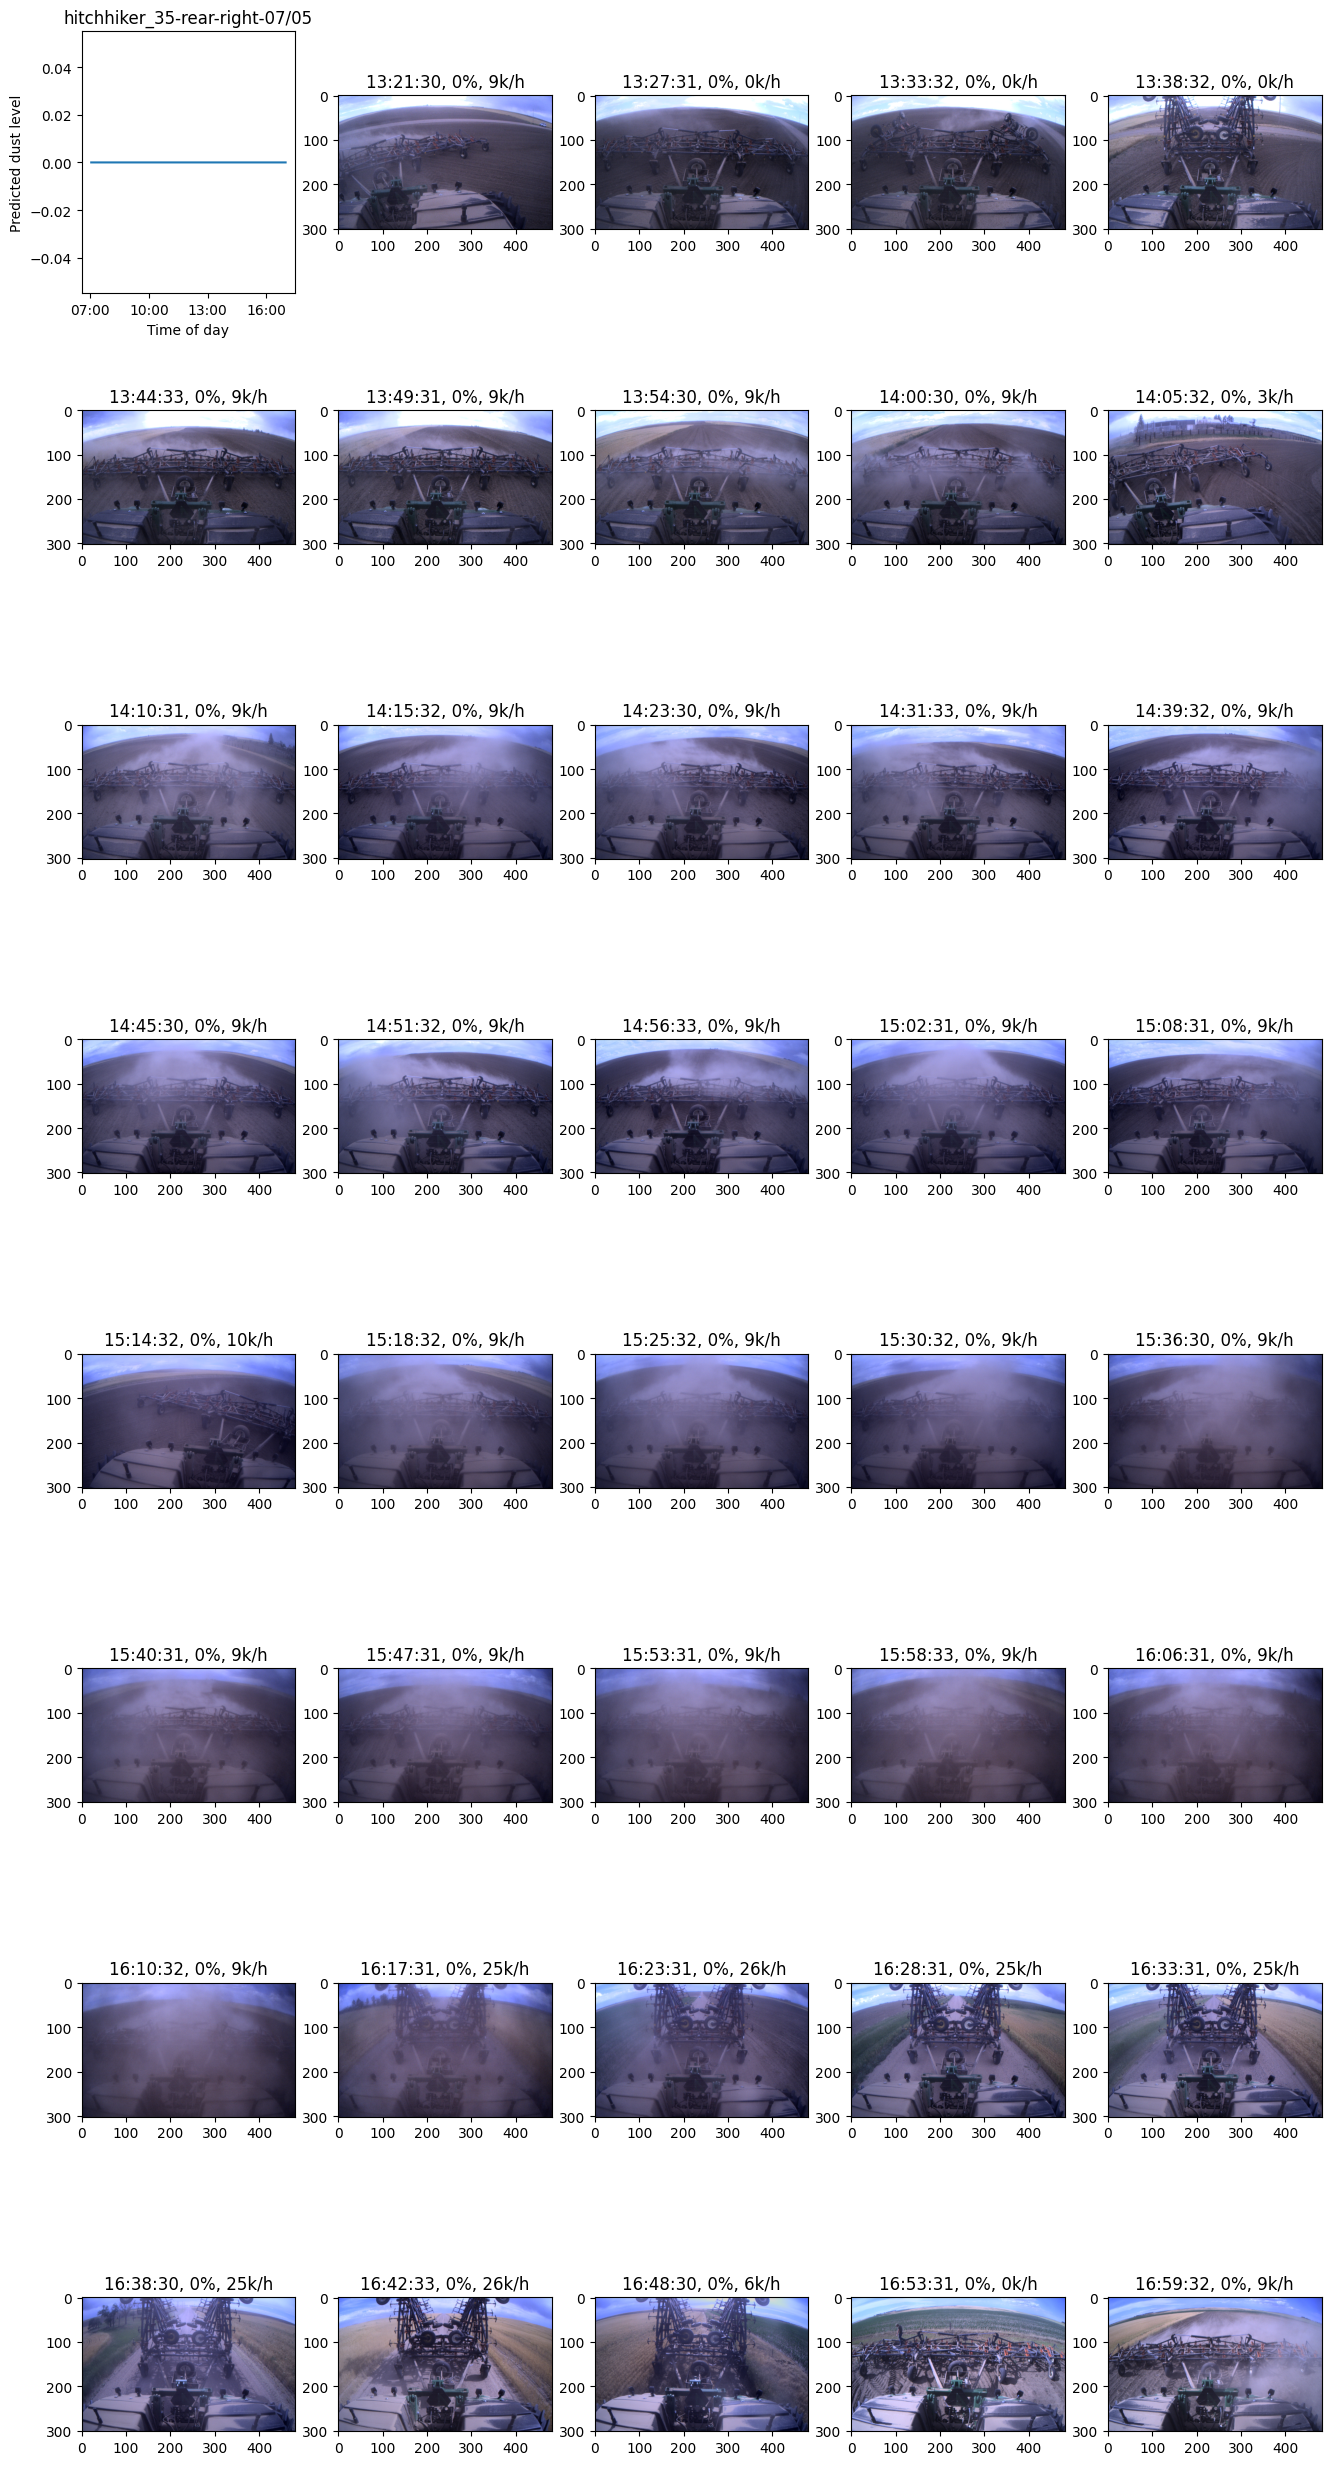

In [70]:
import matplotlib.dates as mdates

def plot(cam_day, movie=None, ncols=20, offset=0, step=1) -> None:
    if movie is None:
        movie = movie = df.iloc[df_groups[cam_day]].sort_values('collected_on_localtime')
    movie_name = '-'.join(cam_day)
    offset = max(0, min(offset, len(movie) - (ncols - 1) * step))
    print(f"Watching {movie_name}. Total images {len(movie)}, viewing {ncols - 1} starting from {offset} with step {step}")
    rows_per_cat = (4 + ncols) // 5
    nrows = rows_per_cat
    fig, ax = plt.subplots(nrows, 5, figsize=(16, nrows * 4))

    ax0 = ax[0][0]
    ax0.plot(movie['collected_on_localtime'], movie['pred_dust_percent'])
    ax0.set_title(movie_name)
    ax0.set_xlabel("Time of day")
    ax0.set_ylabel("Predicted dust level")
    tz = tf.timezone_at(lng=movie.iloc[0]['longitude'], lat=movie.iloc[0]['latitude'])
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax0.xaxis.set_major_locator(mdates.HourLocator(interval=3, tz=tz))
    for j in range(1, ncols):
        idx = offset + j * step - 1
        if idx >= len(movie):
            break
        df_row = movie.iloc[idx]
        im_path = str(Path(data_dir) / df_row['artifact_debayeredrgb_0_save_path'])
        if im_path not in img_cache:
            img_cache[im_path] = cv2.imread(im_path)
        im = img_cache[im_path]
        ax[j // 5][j % 5].imshow(im[::2,::2, ::-1])
        ax[j // 5][j % 5].set_title(f"{df_row['secstr']}, {df_row['pred_dust_percent']:.0f}%, {df_row['speed_kph']:.0f}k/h")
ncols = 40 # len(movie) + 1
# offset = 20
step = 10
cam_day = ("hitchhiker_35", "rear-right", '07/05')
movie = df.iloc[df_groups[cam_day]].sort_values('collected_on_localtime')
offset = get_start_offset_fromtime(cam_day, movie, hour=13, minute=25)
print(offset)
plot(cam_day, movie, ncols, offset, step)

In [207]:
def correlation(group):
    group_ids = df[df['camera_location_grouped'] == group].groupby('group_id').groups
    shared_groups = []
    for  k, v in group_ids.items():
        if len(v) >= 2:
            shared_groups.append(k)
    x = []
    y = []
    for i in range(len(shared_groups)):
        frame = df[df['group_id'] == shared_groups[i]]
        x.append(frame.iloc[0]['pred_dust_percent'])
        y.append(frame.iloc[1]['pred_dust_percent'])
    return np.corrcoef(x,y)[0][1]

In [208]:
print(correlation('implement'))
print(correlation('rear'))
print(correlation('front'))
print(correlation('side'))

0.9946756552789349
0.19128457218425407
-0.07099064839635526
0.4012031450011473
